# Example of usage Spark OCR with Position Finder

## Import Spark OCR transformers and Spark NLP annotators

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
import sys
import os

In [ ]:
# install from PYPI using secret
#%pip install spark-nlp==3.4.0
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# %pip install --user ../dist/spark-ocr-3.12.0+spark30.tar.gz

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [2]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.0.2
Spark NLP version: 3.4.0
Spark OCR version: 3.12.0



In [17]:
from pyspark.ml import Pipeline

from sparkocr.transformers import *
from sparknlp.annotator import *
from sparknlp.base import *
from sparkocr.utils import display_image, display_pdf

## Define OCR transformers and pipeline

In [11]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_text = PdfToText() \
        .setInputCol("content") \
        .setOutputCol("text") \
        .setSplitPage(False) \
        .setStoreSplittedPdf(True) \
        .setExtractCoordinates(True)
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

    sentence_detector = SentenceDetector() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")
    
    entities = pkg_resources.resource_filename('sparkocr', 'resources/test-chunks.txt')

    entity_extractor = TextMatcher() \
        .setInputCols("sentence", "token") \
        .setEntities(entities, "TEXT") \
        .setOutputCol("entity")

    position_finder = PositionFinder() \
        .setInputCols("entity") \
        .setOutputCol("coordinates") \
        .setPageMatrixCol("positions") \
        .setMatchingWindow(20) \
        .setPadding(2)

    draw = PdfDrawRegions() \
        .setInputRegionsCol("coordinates") \
        .setOutputCol("pdf_with_regions") \
        .setInputCol("content") \
        .setLineWidth(1)
    
    pipeline = Pipeline(stages=[
        pdf_to_text,
        document_assembler,
        sentence_detector,
        tokenizer,
        entity_extractor,
        position_finder,
        draw 
    ])
    
    return pipeline

## Read PDF document as binary file

In [5]:
import pkg_resources
pdf_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/alexandria_multi_page.pdf')
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

## Run OCR pipelines

In [12]:
result = pipeline().fit(pdf_example_df).transform(pdf_example_df).cache()

## Display results

In [15]:
result.select("entity", "coordinates").show()

+--------------------+--------------------+
|              entity|         coordinates|
+--------------------+--------------------+
|[[chunk, 0, 9, Al...|[[0, 0, 70.024, 7...|
+--------------------+--------------------+



## Store results to pdf file

In [19]:
pdf = result.select("pdf_with_regions").head().pdf_with_regions
pdfFile = open("result.pdf", "wb")
pdfFile.write(pdf)

72914

## Convert pdf to image and display 


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/alexandria_multi_page.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


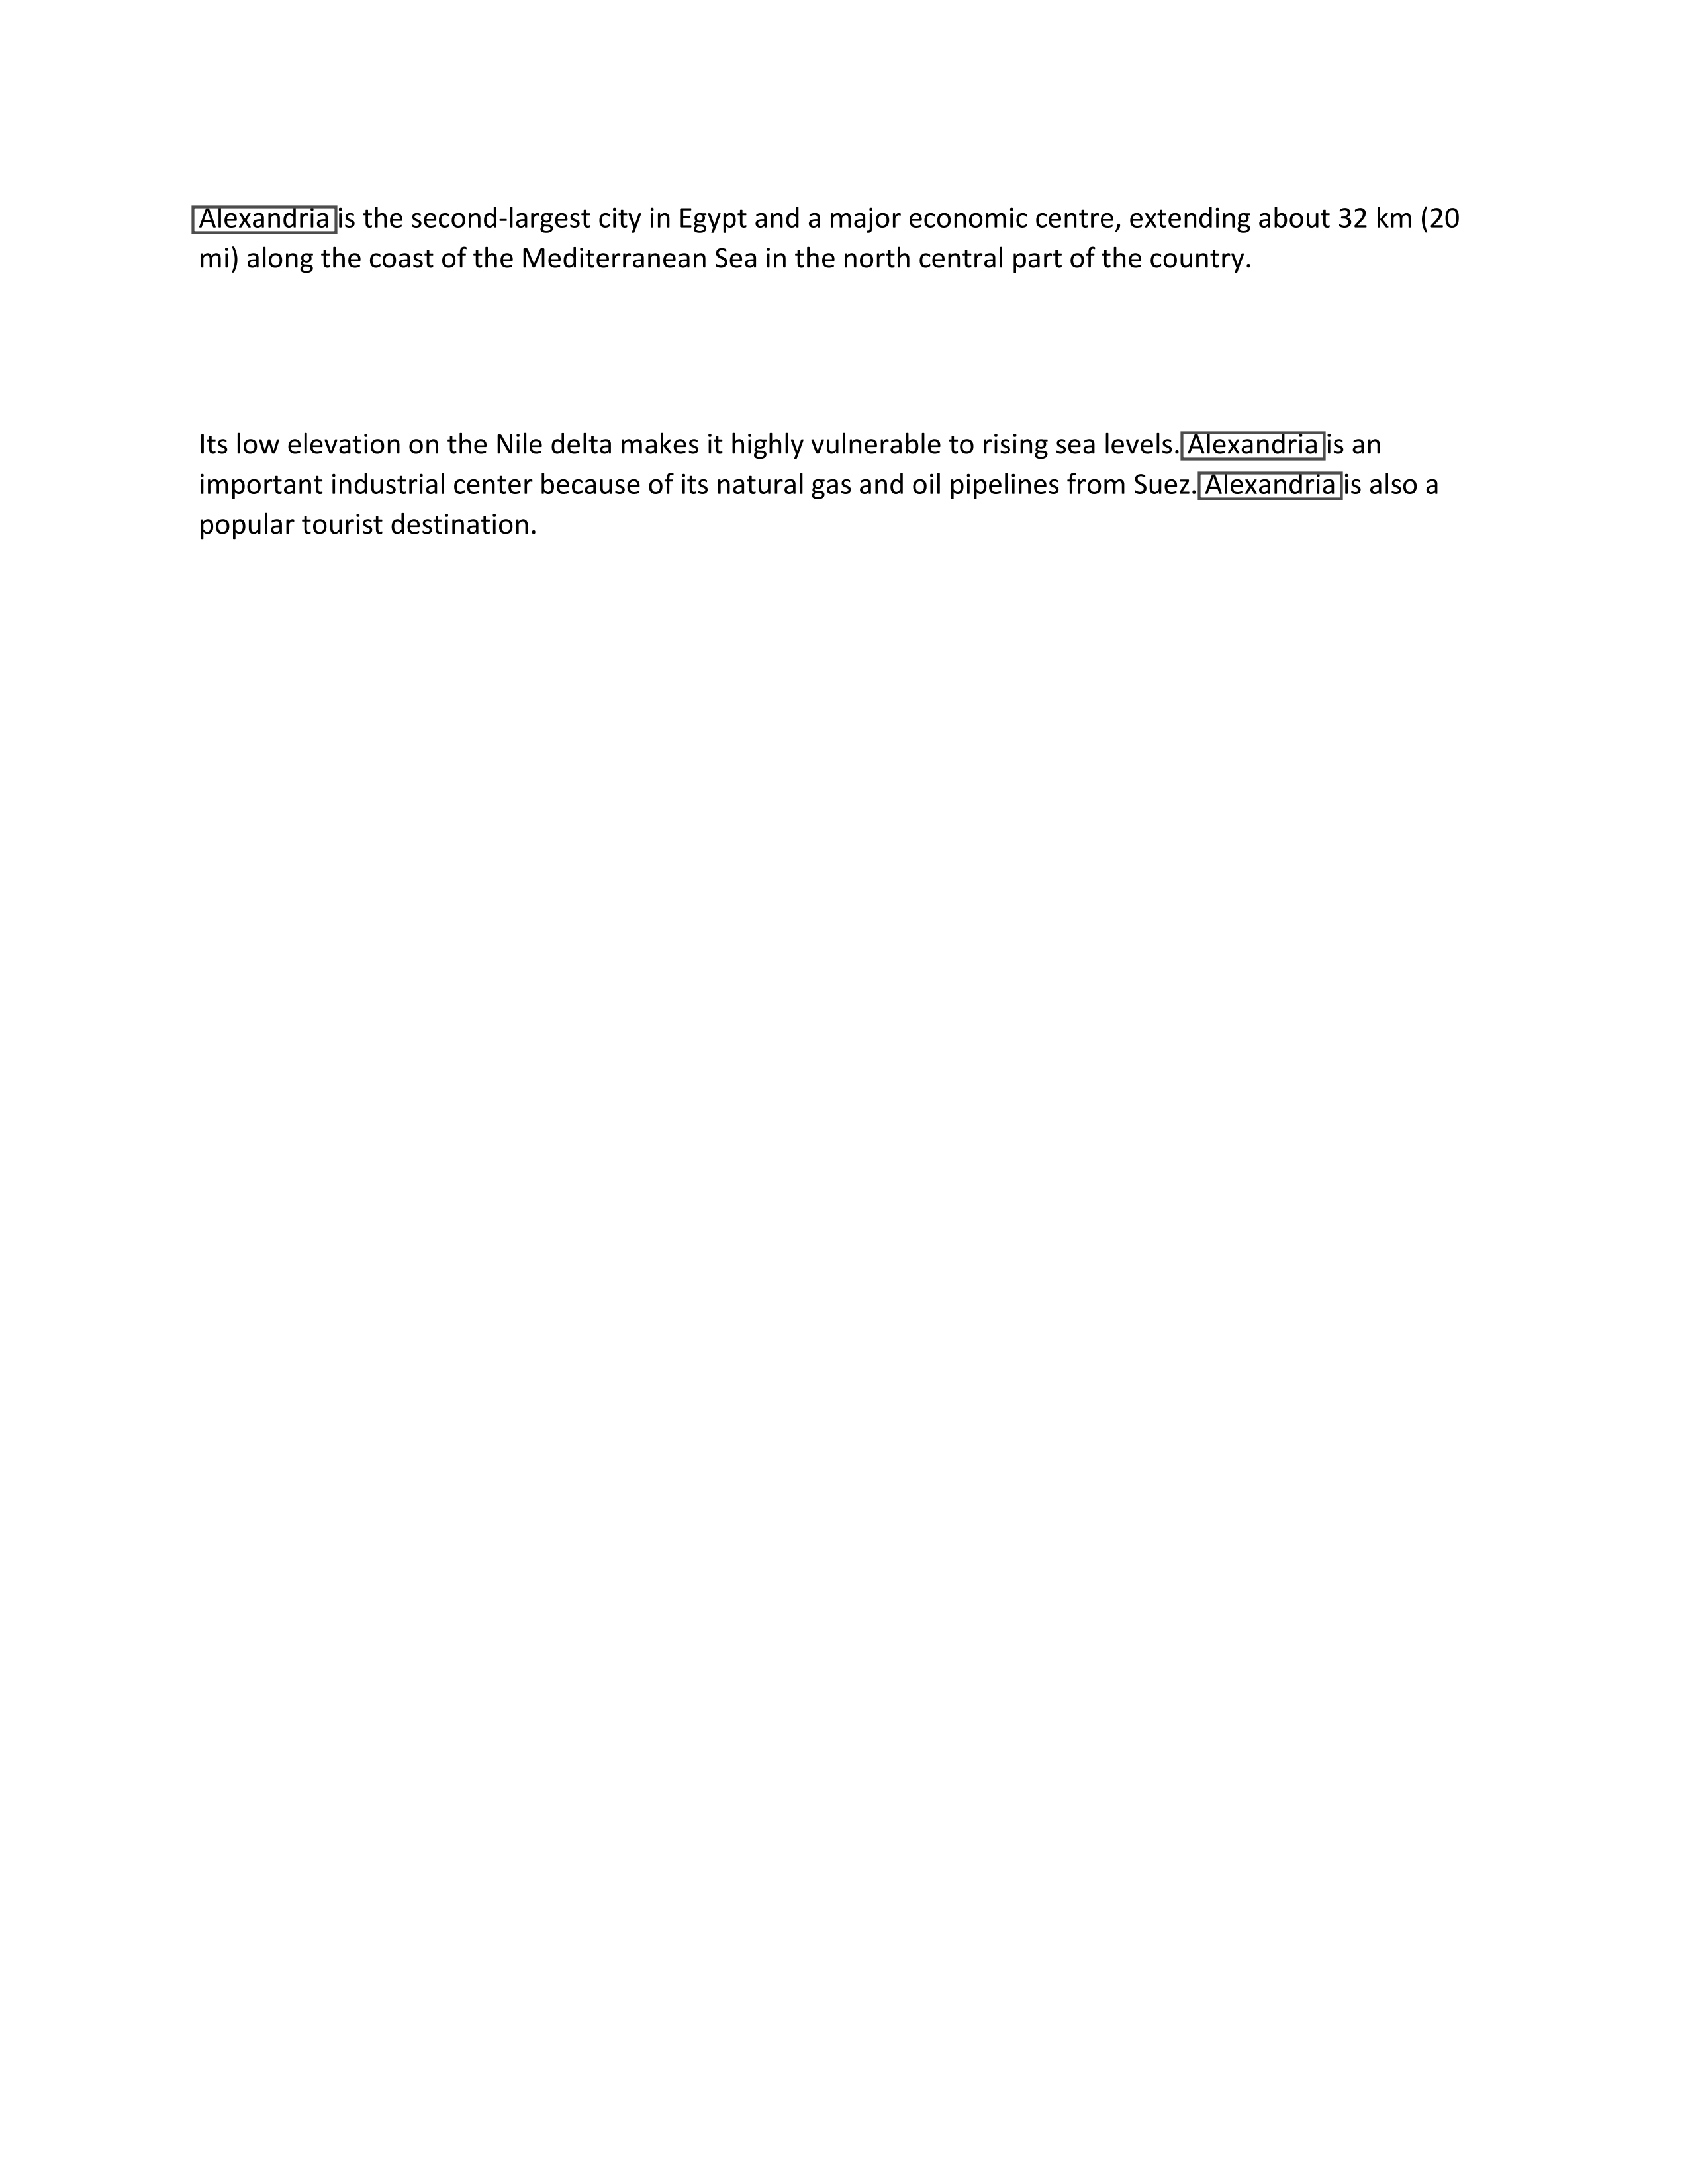


    Image #1:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/alexandria_multi_page.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


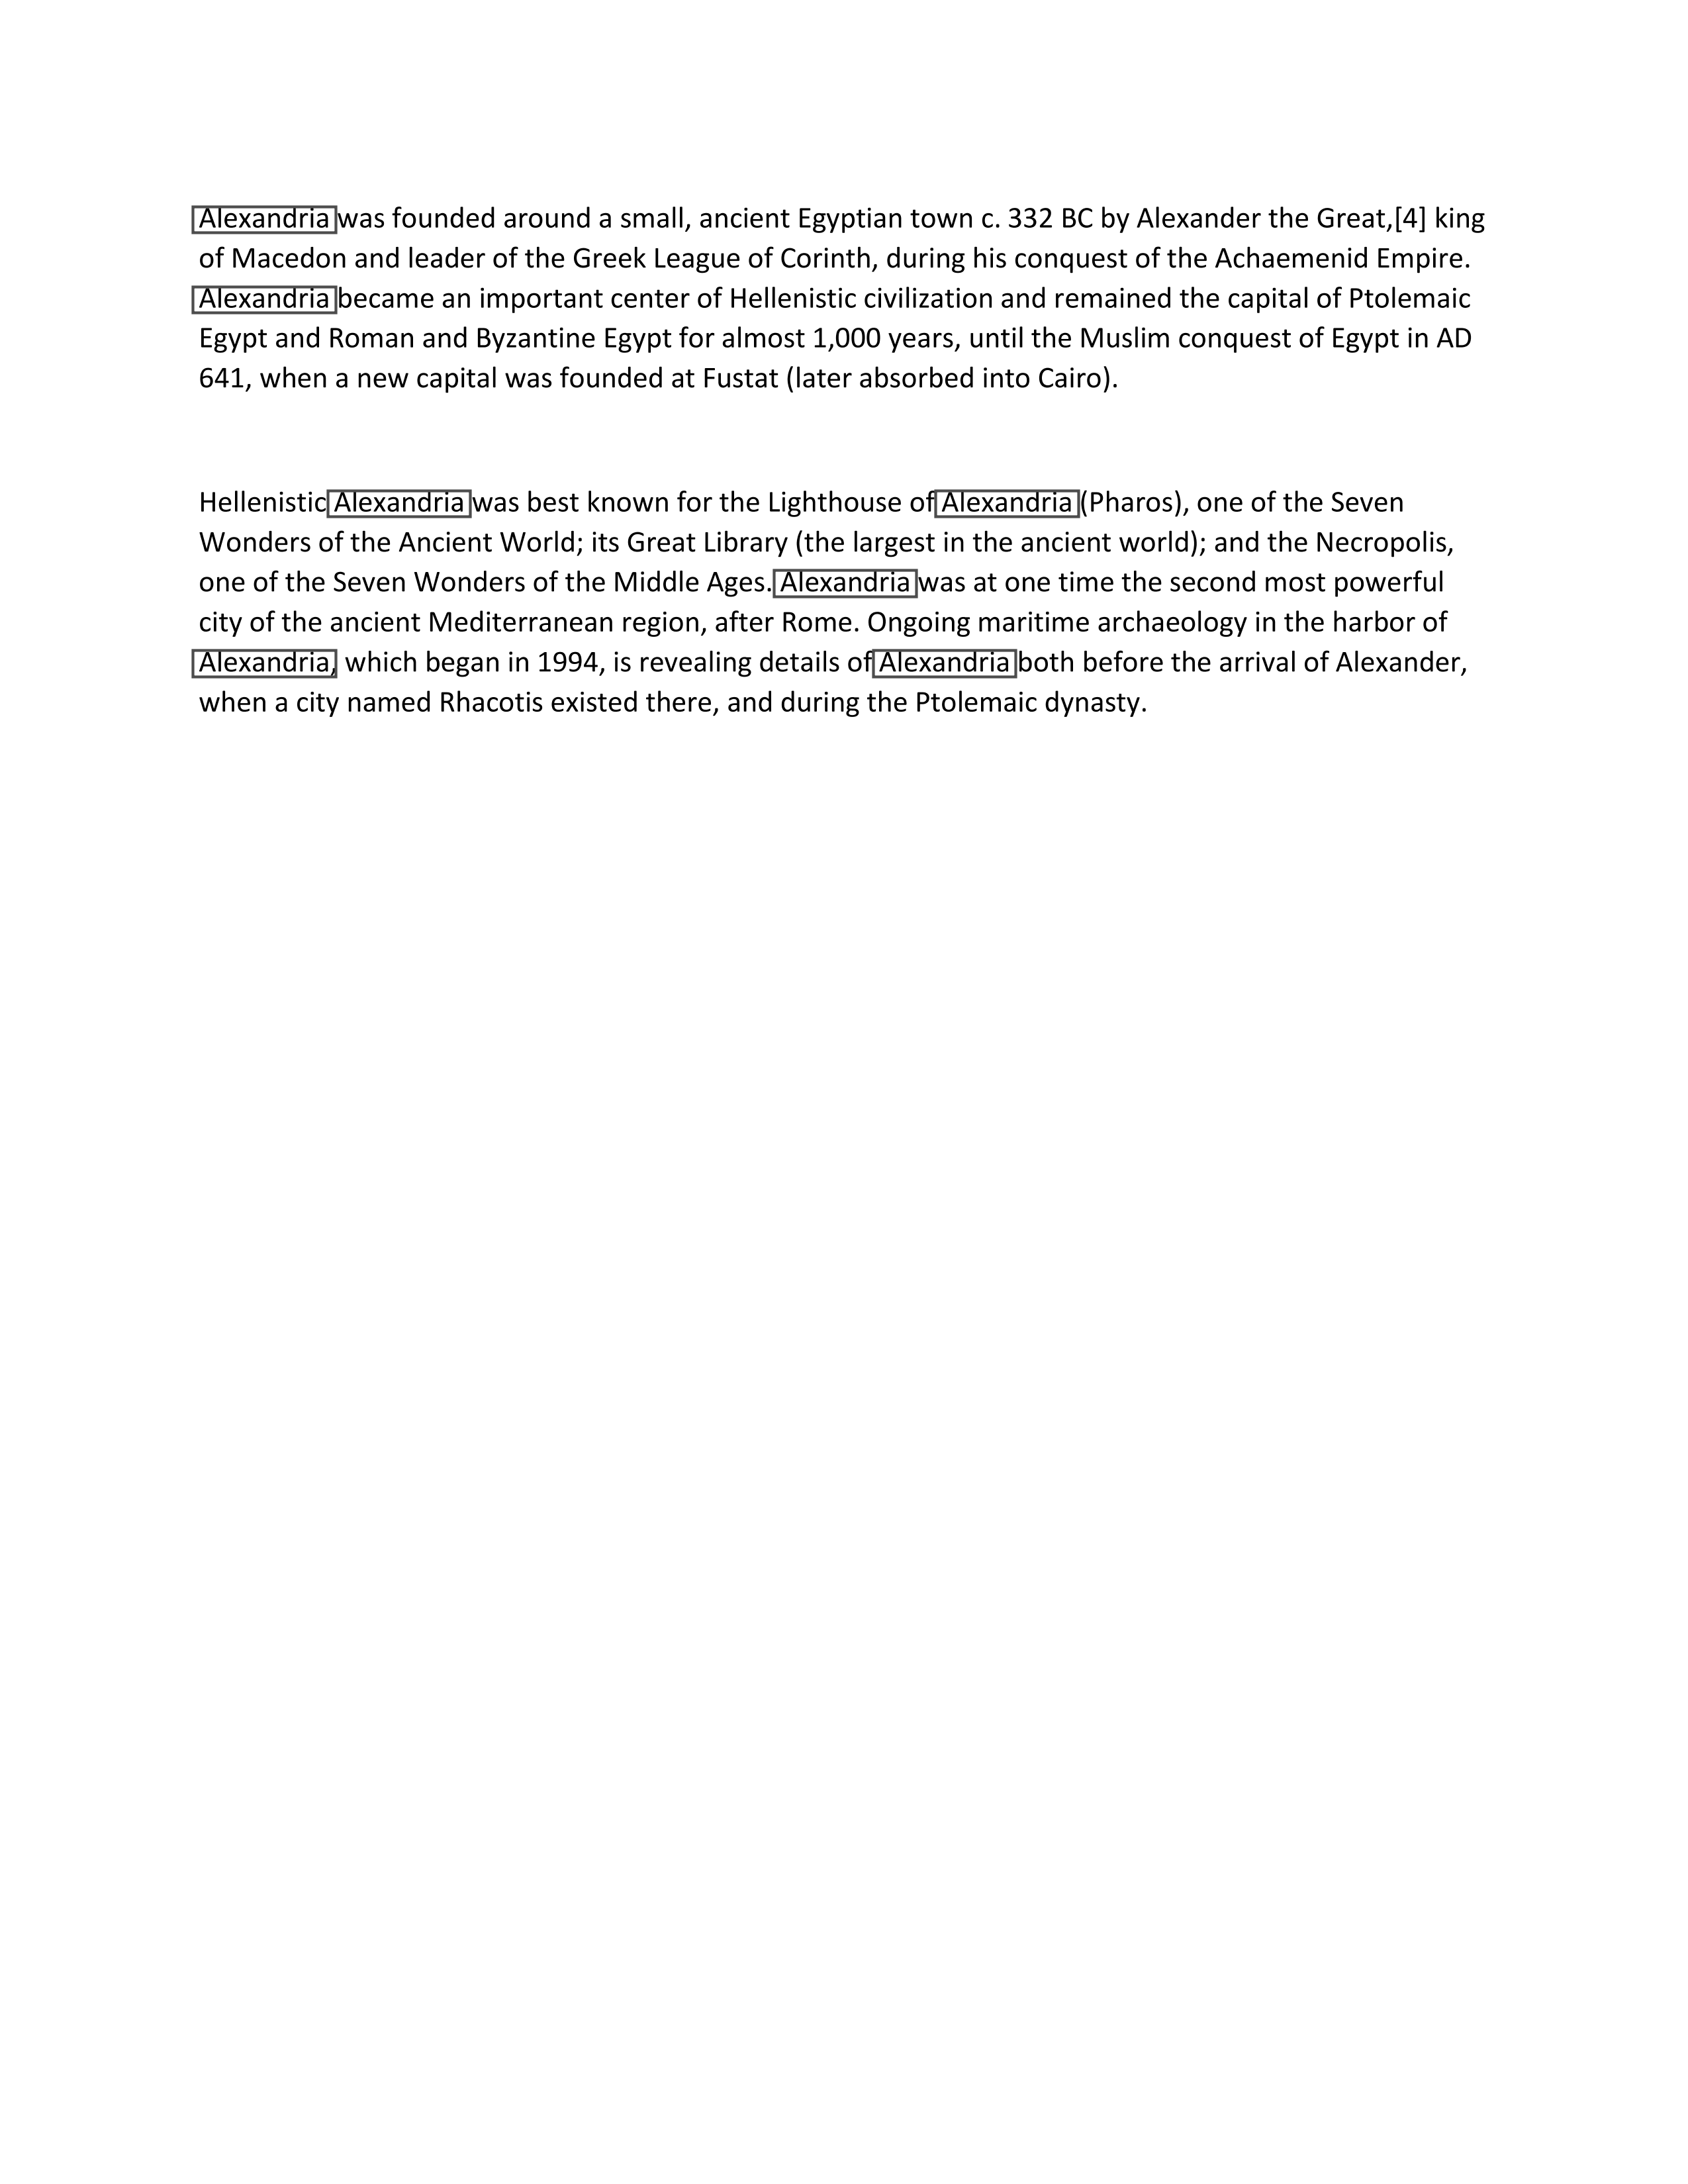

In [22]:
display_pdf(result.select("pdf_with_regions", "path"), field="pdf_with_regions")

In [11]:
%%bash
rm -r -f result.pdf